In [1]:
import tensorflow as tf
tf.__version__

'2.6.1'

In [4]:
import tensorflow as tf
import cv2
import numpy as np
import os,sys,random

np.random.seed(10)

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras import models, layers


def readData(path=r"C:/Users/15019751250/sdxx/trashSorting1/dataset", trainRation=0.9):
    images=[]
    labels=[]
    subdirs=os.listdir(path)
    subdirs.sort()
    print(subdirs)
    classes=len(subdirs)
    
    for subdir in range(classes):
        
        for index in os.listdir(os.path.join(path, subdirs[subdir])):
            
            indexDir = os.path.join(path, subdirs[subdir], index)
            sys.stdout.flush()
            print("label-->dir: {}-->{}".format(subdirs[subdir], indexDir))
            
            for indexdir in os.listdir(indexDir):
                imagePath=os.path.join(indexDir, indexdir)
                img=cv2.imread(imagePath)
                img=cv2.resize(img, dsize=(32,32), interpolation=cv2.INTER_AREA)
                images.append(img)
                labels.append(subdir)
    
    print("读取到的图像与标签集的形状")            
    print(np.array(images).shape)
    print(np.array(labels).shape)
    
    (trainImages, trainLabels),(testImages, testLabels)=makeTrainTestData(images, labels)
    
    
#     print("trainImages: ", trainImages.shape)
#     print("trainLabels: ", trainLabels.shape)
#     print("testImages: ", testImages.shape)
#     print("testLabels: ", testLabels.shape)
    
    np.save("trainImages.npy", trainImages)
    np.save("trainLabels.npy", trainLabels)
    np.save("testImages.npy", testImages)
    np.save("testLabels.npy", testLabels)
    
    return (trainImages, trainLabels),(testImages, testLabels)

In [5]:
import random
np.random.seed(10)

def makeTrainTestData(images, labels, trainRation=0.9):
    c=list(zip(images, labels))
    
    random.shuffle(c)
    
    images, labels= zip(*c)
    
    train_num=int(trainRation*len(images))
    trainImages, trainLabels=images[:train_num], labels[:train_num]
    testImages, testLabels= images[train_num:], labels[train_num:]
    
    return((np.array(trainImages),np.array(trainLabels)), (np.array(testImages),np.array(testLabels)))

In [6]:
def loadData():
    try:
        trainImages=np.load("C:/Users/15019751250/sdxx/trashSorting1/trainImages.npy")
        trainLabels=np.load("C:/Users/15019751250/sdxx/trashSorting1/trainLabels.npy")
        testImages=np.load("C:/Users/15019751250/sdxx/trashSorting1/testImages.npy")
        testLabels=np.load("C:/Users/15019751250/sdxx/trashSorting1/testLabels.npy")
    
    except:
        (trainImages, trainLabels),(testImages, testLabels)=readData()
        
    return (trainImages, trainLabels),(testImages, testLabels)

In [7]:
def ProcessDataset(trainImages,testImages, trainLabels, testLabels):
    lengthTrain=len(trainImages)
    lengthTest=len(testImages)
    
    proTrainimages= trainImages.astype("float32")/255
    proTestimages= testImages.astype("float32")/255
    
    proTrainlabels=np_utils.to_categorical(trainLabels)
    proTestlabels=np_utils.to_categorical(testLabels)
    
    return (proTrainimages, proTestimages),(proTrainlabels, proTestlabels)

In [8]:
if __name__== "__main__":
    
    (trainImages, trainLabels),(testImages, testLabels)=loadData()
    print("以下是读取到的数据集的形状：")
    print("trainImages: ", trainImages.shape)
    print("testImages: ", testImages.shape)
    print("trainLabels: ", trainLabels.shape)
    print("testLabels: ", testLabels.shape)
    print()

以下是读取到的数据集的形状：
trainImages:  (49144, 32, 32, 3)
testImages:  (5461, 32, 32, 3)
trainLabels:  (49144,)
testLabels:  (5461,)



In [9]:
print("以下是预处理后的数据集的形状：")
(proTrainimages, proTestimages),(proTrainlabels, proTestlabels) = \
ProcessDataset(trainImages,testImages, trainLabels, testLabels)
print("proTrainimages: ", proTrainimages.shape)
print("proTestimages: ", proTestimages.shape)
print("proTrainlabels: ", proTrainlabels.shape)
print("proTestlabels: ", proTestlabels.shape)

以下是预处理后的数据集的形状：
proTrainimages:  (49144, 32, 32, 3)
proTestimages:  (5461, 32, 32, 3)
proTrainlabels:  (49144, 10)
proTestlabels:  (5461, 10)


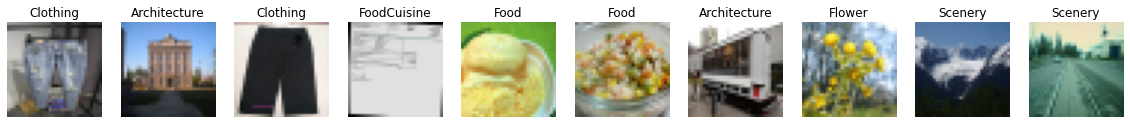

In [10]:
import matplotlib.pyplot as plt

#转为RGB
trainImages = trainImages[...,::-1]
testImages = testImages[...,::-1]

#显示图片
label_dict={0:'Animals',1:'Architecture',2:'Clothing',3:'Flower',4:'Food',5:'Portrait',6:'Scenery',7:'Transportation',8:'BillReceipt',9:'FoodCuisine'}
fig,axs=plt.subplots(1,10,figsize=(20,2))
for i in range(10):
    axs[i].imshow(trainImages[i+100],cmap='gray')
    axs[i].set_title(label_dict[trainLabels[i+100]])
    axs[i].axis('off')   
plt.show()

In [ ]:
from fastapi import FastAPI, Form, Request
from fastapi.templating import Jinja2Templates
import matplotlib.pyplot as plt
import io
from PIL import Image
import numpy as np
import uvicorn

app = FastAPI()

# 创建一个简单的HTML表单
templates = Jinja2Templates(directory="templates")

@app.get("/")
async def read_root(request: Request):
    return templates.TemplateResponse("index.html", {"request": request, "labels": label_dict.values()})

# 处理表单提交
@app.post("/display_images/")
async def display_images(
    request: Request,
    selected_label: str = Form(...),
    start_index: int = Form(...),
    end_index: int = Form(...)
):
    selected_label_index = list(label_dict.values()).index(selected_label)
    selected_images = [trainImages[i] for i in range(100, len(trainImages)) if trainLabels[i] == selected_label_index]

    start_index = max(0, start_index)
    end_index = min(end_index, len(selected_images))

    selected_images = selected_images[start_index:end_index]

    fig, axs = plt.subplots(1, len(selected_images), figsize=(20, 2))
    for i in range(len(selected_images)):
        axs[i].imshow(selected_images[i], cmap='gray')
        axs[i].set_title(selected_label)
        axs[i].axis('off')

    plt.savefig('static/selected_images.png')
    plt.close()

    with open("static/selected_images.png", "rb") as image_file:
        image_data = image_file.read()
    
    return templates.TemplateResponse("display_images.html", {"request": request, "selected_label": selected_label, "image_data": image_data, "start_index": start_index, "end_index": end_index})

if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8000)
